# Dataset 2 - Friedman 1

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE Logit Loss to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is linear. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import friedman1Dataset
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

In [4]:
# Parameters
n_samples = 100
n_features = 10
mean = 0
variance = 1


## Dataset

Friedman 1 Dataset 

*   $y(X) = 10 * sin(pi * X_0 * X_1) + 20 * (X_2 - 0.5) ** 2 + 10 * X_3 + 5 * X_4 + noise * N(0, 1)$.
* Only 5 features used to calculate y 
* Noise is Gaussian 
* 1000 datapoints and 10 features used in the following experiment 

In [5]:
X, Y = friedman1Dataset.friedman1_data(n_samples,n_features)

         X0        X1        X2        X3        X4        X5        X6  \
0  0.436789  0.992541  0.659134  0.174479  0.494078  0.731604  0.984635   
1  0.906640  0.010300  0.467334  0.334750  0.092309  0.647841  0.686549   
2  0.654108  0.911288  0.322373  0.026683  0.582559  0.777605  0.517847   
3  0.998522  0.945500  0.377959  0.468328  0.557937  0.662474  0.673165   
4  0.496404  0.711550  0.892230  0.940239  0.227084  0.121928  0.760672   

         X7        X8        X9          Y  
0  0.029576  0.308181  0.133219  14.568512  
1  0.280296  0.882284  0.133781   4.126582  
2  0.241520  0.231090  0.685839  13.281635  
3  0.837355  0.238505  0.687735   9.309093  
4  0.945321  0.994090  0.478018  22.592192  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     23.48
Date:                Wed, 20 Oct 2021   Prob (F-statistic):           6.34e-21
Time:                        20:28:18   Log-Likelihood:                -77.312
No. Observations:                 100   AIC:                             176.6
Df Residuals:                      89   BIC:                             205.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.721e-15      0.056    3.1e-14      1.0

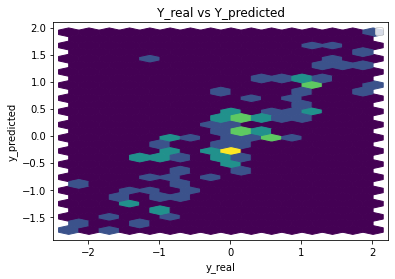

Performance Metrics
Mean Squared Error: 0.27482132694843053
Mean Absolute Error: 0.4024431742808203
Manhattan distance: 40.24431742808203
Euclidean distance: 5.242340383344358


In [6]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [7]:
n_epochs = 5000
error = 0.001
batch_size = n_samples//2

## GAN Model

In [8]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Training GAN for n_epochs number of epochs** 

In [9]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


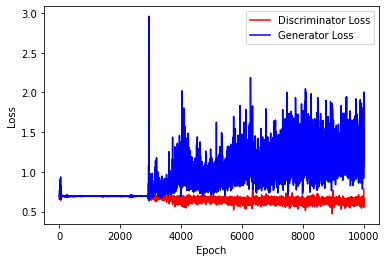

In [11]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

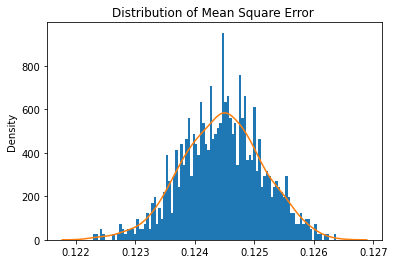

Mean Square Error: 0.12445936320158703


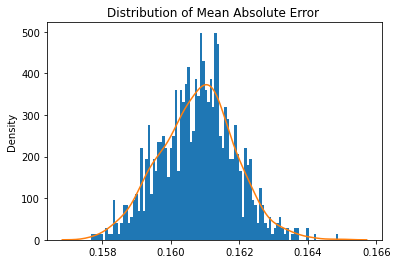

Mean Absolute Error: 0.16078014897994697


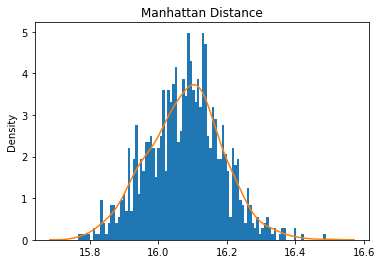

Mean Manhattan Distance: 16.0780148979947


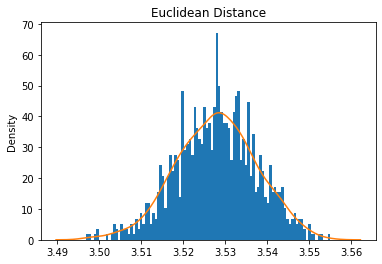

Mean Euclidean Distance: 3.527866836952462


In [12]:
train_test.test_generator(generator,real_dataset,device)

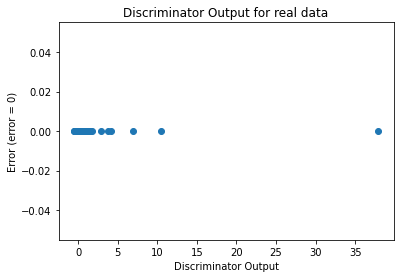

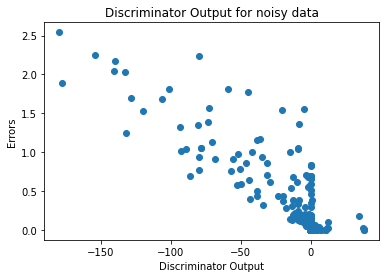

In [13]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [14]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)
criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs needed 30000


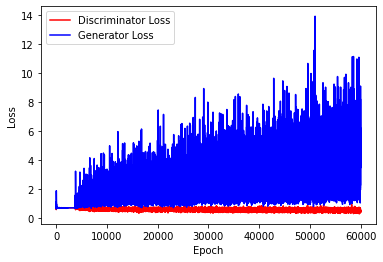

In [15]:
train_test.training_GAN_2(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size,error,criterion,device)

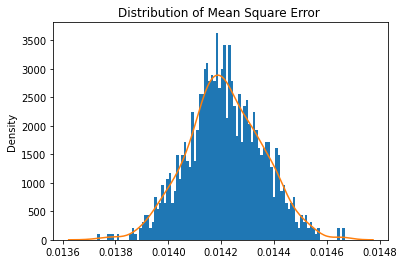

Mean Square Error: 0.01421463924832751


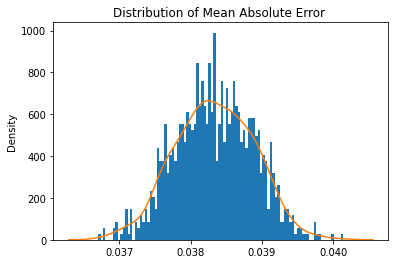

Mean Absolute Error: 0.03833567165069282


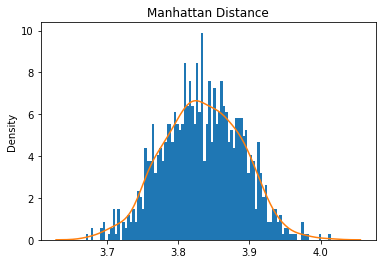

Mean Manhattan Distance: 3.833567165069282


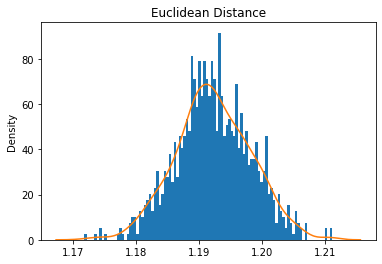

Mean Euclidean Distance: 1.1922366020710262


In [16]:
train_test.test_generator(generator,real_dataset,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [17]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

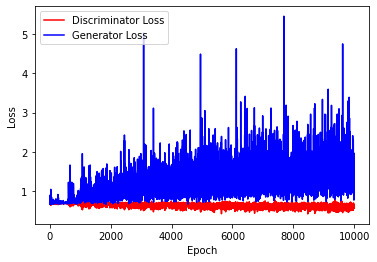

In [18]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

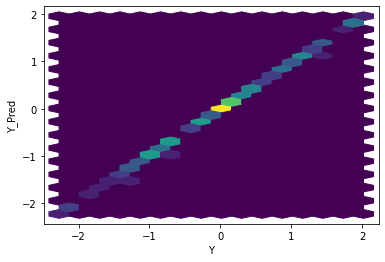

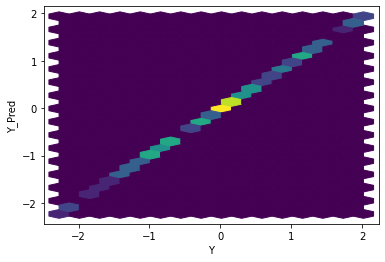

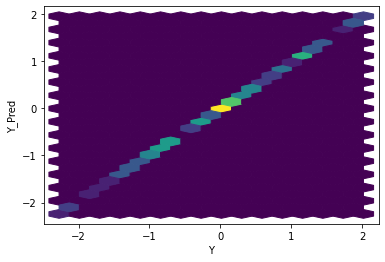

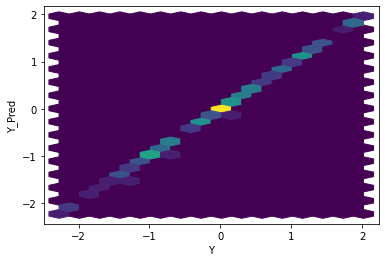

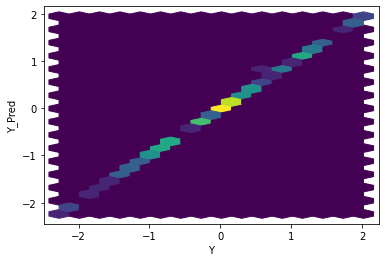

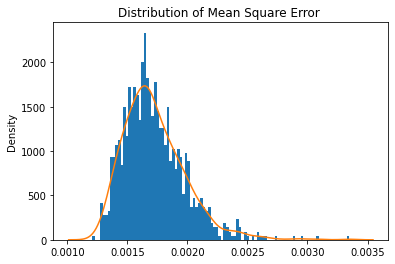

Mean Square Error: 0.0017263174580691401


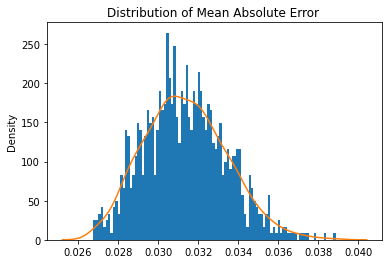

Mean Absolute Error: 0.031362880392335354


Mean Manhattan Distance: 3.1362880392335355


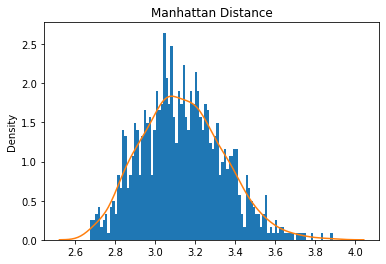

Mean Euclidean Distance: 0.4143787762632288


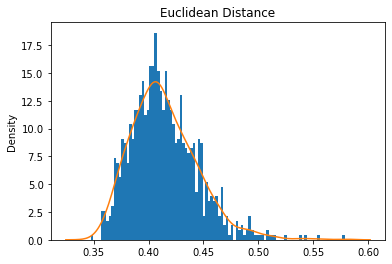

In [19]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

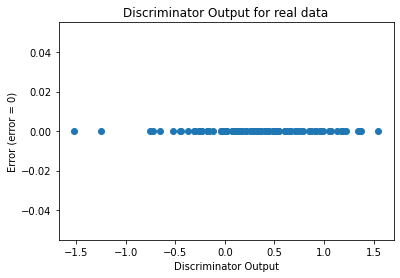

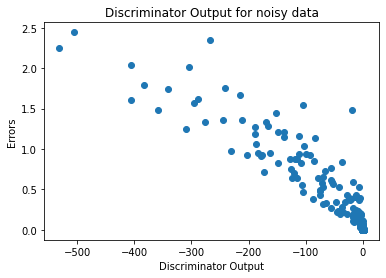

In [20]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [21]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

Number of epochs 1529


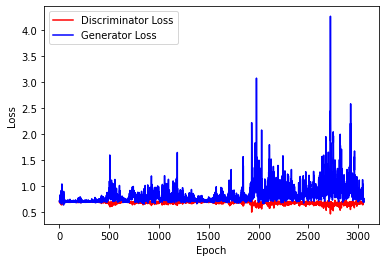

In [22]:
ABC_train_test.training_GAN_2(disc,gen,disc_opt,gen_opt,real_dataset,batch_size, error,criterion,coeff,mean,variance,device)

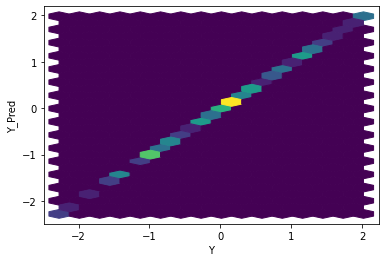

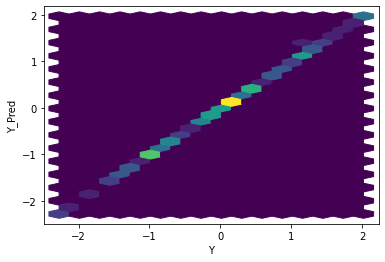

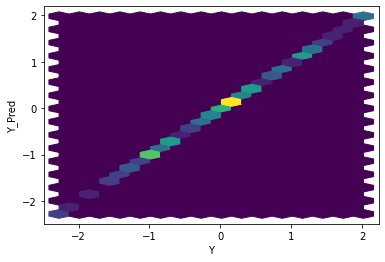

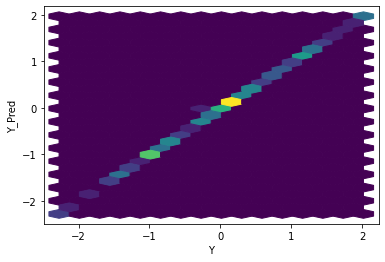

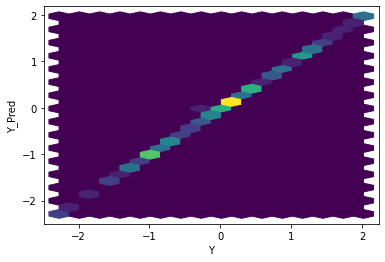

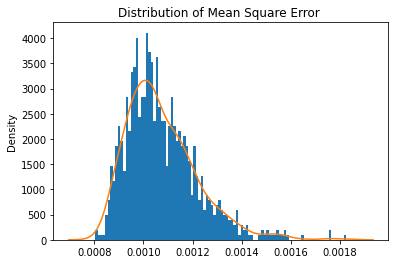

Mean Square Error: 0.001074268210139856


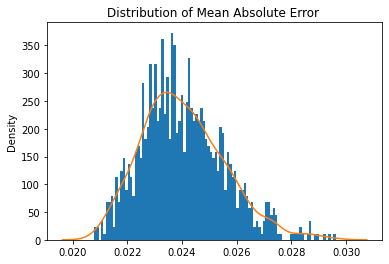

Mean Absolute Error: 0.02403898802967742


Mean Manhattan Distance: 2.403898802967742


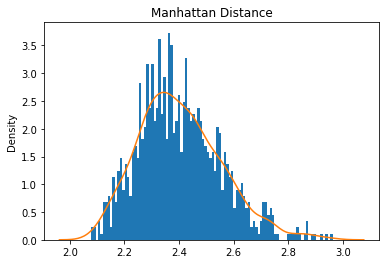

Mean Euclidean Distance: 0.3270604533946309


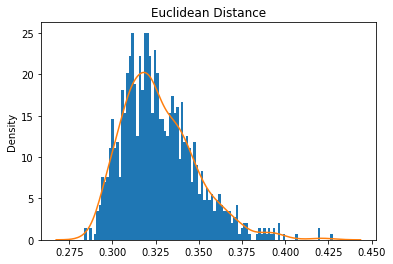

In [23]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)